In [1]:
import pandas as pd
import numpy as np

import requests

from io import BytesIO
from zipfile import ZipFile

from functools import partial

# Task 1

## Data download

I downloaded the data from IPUMS-CPS, using the monthly data (except for firm size, which is in ASEC) for all availible months. I used all data from 1976 onwards. I selected the following variables:
- Demographics: `AGE`, `SEX`, `RACE`, `MARST` (marital status), `NCHILD` (number of children in household), `EDUC` (Educational attainment recode
)
- Geographic variables: `STATEFIP`, `METAREA`, `COUNTY`, `METFIPS`
- Work information: 
    * `OCC2010`: harmonized occupation coding scheme based on the Census Bureau's 2010 occupation classification scheme 
    * `IND1990`: harmonized industry coding scheme based on the  1990 Census Bureau industrial classification system
    * `EMPSTAT`: Employment status
    * `UHRSWORK1`: Hours usually worked per week at main job
    * `WKSTAT`: Full or part time status
    * `EMPSAME`: Still working for same employer
    * `LABFORCE`: Labor force status
    * `EARNWEEK`: Weekly earnings
    * `MULTJOB`: Whether worked more than one job in the past week
    * `FIRMSIZE`: Number of employees
    
That's a total of 20 variables (to check if you decide to do the download the data yourself).

In [2]:
#data = pd.read_csv('cps_data.csv')
data = pd.read_stata('cps_data.dta')

## Data Cleaning

I remove a lot of NIU, unknown, etc. values (set them to NA):
- For `EARNWEEK` they are coded as 9999.99
- For `FIRMSIZE` they are coded as 0
- For `MULTJOB` they are coded as 0 (after that I transform this to bool by subtracting 1)
- For `EMPSAME` they are coded as 96, 97, 99 (after that I transform this to bool by subtracting 1)
- For `EMPSTAT` they are coded as 0
- For `UHRSWORK1` they are coded as 999, 997
- For `LABFORCE` they are coded as 0 (after that I transform this to bool by subtracting 1)
- For `SEX` they are coded as 9
- For `COUNTY` they are coded as 0
- For `IND1990` they are coded as 0 and 998
- For `OCC2010` they are coded as 9999 and 9920
 
There are some NIUs which could be set to NA for categorical variables, but I leave that as it is for now.

I also create some new variables, to help with analysis later:
- `employed`: whether a person is employed, set to `True` if `EMPSTAT` is 10 or 12 (relevant for people in the LF)

Finally, I remove all ASEC entries. This is ok, as we are currently not using `FIRMSIZE`, if we were to use it we would have to do some matching first.

In [3]:
# Variable name/NIU values pairs
NIU_values = {
    'EARNWEEK': [9999.99],
    'FIRMSIZE': [0],
    'MULTJOB': [0],
    'EMPSAME': [96, 97, 99],
    'EMPSTAT': [0],
    'UHRSWORK1': [999, 997],
    'LABFORCE': [0],
    'SEX': [9],   
    'COUNTY': [0],
    'IND1990': [0, 998],
    'OCC2010': [9999, 9920],
}

In [4]:
# If we only have 0-1 for bool vars, it means they have already been cleaned
# if not, transform MULTJOB, LABFORCE and EMPSAME to bool (by subtracting 1)
bool_vars = ['MULTJOB', 'LABFORCE', 'EMPSAME']

for var in bool_vars: 
    if not ((data[var].max() == 1) & (data[var].min() == 0)):
        
        # Clean
        data.loc[data[variable].isin(nius), variable] = None
        
        # Subtract one (we can not transform to bool, pandas has no nullable boolean column)
        data.loc[:, var] = data[var]-data[var].min()
    
    del NIU_values[var]
    
# Set NIU values to None
for variable, nius in NIU_values.items():
    data.loc[data[variable].isin(nius), variable] = None

In [5]:
# Create employed variable
data['employed'] = data['EMPSTAT'].isin([10,12])

In [6]:
# Remove ASEC stuff
data = data.loc[data['ASECFLAG'] != 1, :]

## Commuting zones

CPS data has no micro areas (those are only in Census), so I do the matching by counties, applying the corrections needed due to counties merging, splitting etc., as described [here](https://www.ddorn.net/data/FIPS_County_Code_Changes.pdf). I use the file under [[E7]](https://www.ddorn.net/data/cw_cty_czone.zip) on Dorn's website for the matching.

In [7]:
# Download the matching file
content = requests.get('https://www.ddorn.net/data/cw_cty_czone.zip')

# Unzip it
f = ZipFile(BytesIO(content.content))

# To pandas you go
cz_matching = pd.read_stata(f.open('cw_cty_czone.dta')).astype(int)

# Add the fixes needed, as described in the doc above
fixes = pd.DataFrame({'czone': [27603, 7000, 28900], 
                      'cty_fips': [46131, 12086, 8014]})
cz_matching = pd.concat([cz_matching, fixes])

# Matching
if 'czone' not in data.columns:
    data = data.merge(cz_matching, left_on = 'COUNTY', right_on = 'cty_fips', how = 'left')

# How many people have no czone/county?
no_czone = 100-100*data['czone'].count()/data.shape[0]
no_county = 100-100*data['COUNTY'].count()/data.shape[0]

# Clean up
data.drop(columns=['cty_fips'], errors = 'ignore', inplace = True)
del f, content, cz_matching

In [8]:
print(f'Note that {no_county:.1f}% of records have no county data (and {no_czone:.1f}% no commuting zone data).')

Note that 78.9% of records have no county data (and 78.9% no commuting zone data).


## Checking how many households carry over each month

Here I simply check what % of households in a given month were also surveyed the previous month, 2 months ago, and 3 months ago. 
The linkage rate should be 75% for 1 month lag, 50% for 2 month lag and 25% for 3 months lag (well, or somewhat bellow these numbers, as it turns out).

The technique I use to compute this is the following (given here 1 month, similar for 2 and 3):
- First, order the data by IDs, and within IDs by date
- Create a column `prev_month` by subtracting 1 month from the month column
- Now if id and its 1 cell lag match, and also 1 cell lag of month and previous month match, it means that in the previous month the same household was also surveyed

In [9]:
# First, let's create a date column (the first of each month) from year and month
year_month = data['YEAR'].astype('str') + ' ' + data['MONTH'].astype('str')
data['date'] = pd.to_datetime(year_month)

# Create a dataframe with just household id + date, sort first by id, then date
households = data[['CPSID', 'date']].drop_duplicates()
households = households.sort_values(['CPSID', 'date'], ascending = False)

# A workaround bc of pandas bug
m1, m2, m3 = (-1, -2, -3)

# Month of the lag x cell and current date - x months
# We add this because households can appear after an 8 month break - we need to control for it
households['prev_1_month'] = households['date'] - pd.DateOffset(months = 1)
households['prev_2_month'] = households['date'] - pd.DateOffset(months = 2)
households['prev_3_month'] = households['date'] - pd.DateOffset(months = 3)

# Check if households has previous month data by equating current and lag ID and lag month and previous month
# This "works" because how the data is sorted
households.eval('prev_1_month_in_data = (CPSID == CPSID.shift(@m1)) & (prev_1_month == date.shift(@m1))', inplace = True)
households.eval('prev_2_month_in_data = (CPSID == CPSID.shift(@m2)) & (prev_2_month == date.shift(@m2))', inplace = True)
households.eval('prev_3_month_in_data = (CPSID == CPSID.shift(@m3)) & (prev_3_month == date.shift(@m3))', inplace = True)

# Now compute the linkage rates for all months, remove first month
vals = ['prev_1_month_in_data', 'prev_2_month_in_data', 'prev_3_month_in_data']
linkage_rates = households.pivot_table(index = 'date', values = vals, 
                                       aggfunc = np.mean)
linkage_rates = linkage_rates.iloc[3:,]

In [10]:
# A quick plot of the linkage rates, with 75%, 50% and 25% shown in red
plot = linkage_rates.plot()
plot.axhline(y = 0.75, color = 'red', linestyle=':')
plot.axhline(y = 0.50, color = 'red', linestyle=':')
plot.axhline(y = 0.25, color = 'red', linestyle=':')

plot.legend(['1 month lag', '2 months lag', '3 months lag'])
plot.set_title('Linkage rates for 1,2 and 3 month lags')
plot.set_ylim((0,1))

(0, 1)

We see that the actual linkage values are close to the predicted ones. Even the abnormal drops correspond to [documented cases](https://cps.ipums.org/cps/cps_linking_documentation.shtml#unlinkable_samples).

In [11]:
# Clean up
del year_month, households

## Saving the data

Here I save the current dataset to a csv. Note that it only differs from what you would get by downloading it from IPUMS yourself by
- data cleaning I did
- commuting zones matching

I save the data to a stata file.

In [12]:
# data.to_stata('cps_data.dta', write_index = False)

## Tabulations

First, I filter the data to persons between 25 and 55 years old, which are in the labor force

In [13]:
# Filter data
data_f = data.query('AGE >= 25 & AGE <= 55 & LABFORCE == 1')

f_share = 100*data_f.shape[0]/data.shape[0]
print(f'After filtering, we keep {f_share:.1f}% of the original data')

After filtering, we keep 34.9% of the original data


### Job to job transitions
Here I check the job to job transitions that are accompanied by an occupation transition, industry transition, or both.

Note that I have to do some additional filtering:
1. I remove entries where `EMPSTAT` is NA (so that we are only dealing with employed or umeployed people)
2. I remove all entries where `OCC2010` or `IND1990` are None - as you can see bellow, this has almost no effect, as those in labor force have meaningful industry and occupation values.

The technique for computing these shares is similar to what I used to compute the carry-over shares above. What I do is
- Sort the data by id, then date
- Create lag variables for id, employed ,occupation, industry and month, as well as previous month variable (current month - 1)
- Filter the data to entries where id matches lag id, lag month matches previous month, employed and its lag are both true and `EMPSAME == False`. These are the entries where a job change has occured.
- To get the proportion of job changes that coincided with indusry/occupation changes, I check for how many changes do the lag and current variable of industry/occupation coincide

Note that to compute the shares of changes that conicided with the industry, I use weights. I do this as follows:
$$
\mu_t = \sum_i^{n_t} w_{i,t} \cdot c_{i,t},
$$
where $\mu_t$ is the weighted average for a certain period, $w_{i,t}$ is simply the `WTFINL` variable for that record, and $c_{i,t}$ is the binary variable showing whether the change (in industry, occupation, or both) has occured.

In [14]:
# Filter employed
data_f = data_f.dropna(subset=['EMPSTAT'])

emp_filter_size = data_f.shape[0]
emp_filter_share = 100*emp_filter_size/data_f.shape[0]
print(f'After employed filtering, we keep {emp_filter_share:.1f}% of the filtered data')

data_f = data_f.dropna(subset = ['IND1990', 'OCC2010'])
na_filter_share = 100*data_f.shape[0]/emp_filter_size
print(f'After NA filtering, we keep {na_filter_share:.1f}% of the filtered data')

After employed filtering, we keep 100.0% of the filtered data
After NA filtering, we keep 99.5% of the filtered data


In [15]:
# Sort the data first by individual ID, then by date
data_f = data_f.sort_values(['CPSIDP', 'date'], ascending = False)

# Lag employed
data_f['lag_employed'] = data_f['employed'].shift(-1)

# Lag and previous month
data_f['prev_month'] = data_f['date'] - pd.DateOffset(months = 1)

# Check if id and month match, and if industry or occupation, or both, change
data_f.eval('same_id = CPSIDP == CPSIDP.shift(@m1)', inplace = True)
data_f.eval('month_ok = date.shift(@m1) == prev_month', inplace = True)

data_f.eval('occ_changes = OCC2010 != OCC2010.shift(@m1)', inplace = True)
data_f.eval('ind_changes = IND1990 != IND1990.shift(@m1)', inplace = True)
data_f.eval('both_change = occ_changes & ind_changes', inplace = True)

In [16]:
# Helper function for computing the weighted mean (weighted column name fixed)
weight_col = 'WTFINL'
def wght_mean(data, var_name):
    return np.average(data[var_name], weights = data[weight_col])

# Main function
def weighted_means(data):
    return pd.Series({
        'Industry': wght_mean(data, 'ind_changes'),
        'Occupation': wght_mean(data, 'occ_changes'),
        'Both': wght_mean(data, 'both_change')
    })

In [17]:
# Helper function to produce results, graph them, and save the data
# Will be used many times here
def analyze(data, filter_str, file_name, graph_title):
    # Get the events by filtering
    events = data.query(filter_str).copy()

    share = 100*events.shape[0]/data.shape[0]
    events_pm = events.shape[0]/(data['date'].unique().shape[0]-1)

    print(f'Our sample consists of {share:.1f}% of input data')
    print(f'On average we observe {events_pm:.1f} events per month')
    
    # Compute the changes for each month (using the weighted mean)
    results = events.groupby('date').apply(weighted_means)

    # Save the results to a csv file
    results.to_csv(file_name)

    # Show the results in a quick graph
    plot = results.plot()
    plot.set_title(graph_title)
    plot.set_ylim((0,1))
    
    # Clean up
    del events, results

Our sample consists of 0.8% of input data
On average we observe 364.3 events per month


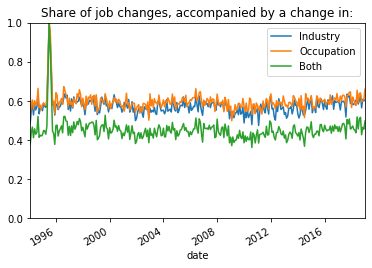

In [18]:
# Produce results
analyze(data_f,
       'same_id & month_ok & EMPSAME == False & employed == True & lag_employed == True',
       'Job to job changes.csv',
       'Share of job changes, accompanied by a change in:')

Note that the graph starts in 1994, because this is the first date for which `EMPSAME` is availible. 

### Unemployment to employment transitions

The procedure here is very similar to the one for job to job transitions. The only change is:
- When detecting U2E transitions, I use, beside the id and month consistency condition, a condition that `employed` has to be true in the current period, and that lag of `employed` has to be false.

This procedure takes the previous industry/occupation of the person to be the industry/occupation they listed in the previous month, when they were unemployed. At the end of the document I provide an alternative version, where I take the previous occupation/employment to be the occupation/employment the person held last time he was employed, if he was employed before 

Our sample consists of 0.8% of input data
On average we observe 384.2 events per month


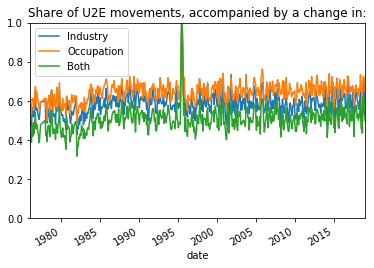

In [19]:
# Produce results
analyze(data_f,
        'same_id & month_ok & employed == True & lag_employed == False',
        'U2E movements.csv',
        'Share of U2E movements, accompanied by a change in:')

### More aggregate occupation and industry measures

There are no more aggregate occupation/industry variables in the CPS, however, on the description pages for [industry](https://cps.ipums.org/cps-action/variables/IND1990#codes_section) and [occupation](https://cps.ipums.org/cps-action/variables/OCC2010#description_section) variables, an aggregation is suggested, this is the one I follow. All the procedures to obtain the shares are the same as with the original variables.

In [20]:
# Here we provide the edges of the interval on which group the variables
# Note that these are somewhere between categories (some numbers are not used)
ind_bins = [-1, 35, 55, 65, 395, 480, 575, 695, 720, 760.5, 795, 811,
            895, 935, 1000]
occ_bins = [-1, 450, 750, 970, 1250, 1545, 1570, 1990, 2070, 2170, 2570, 2950,
            3550, 3670, 3970, 4170, 4270, 4670, 4970, 6000, 6150, 6770, 6950,
            7650, 8970, 9770, 9900, 10000]

In [21]:
# Create new aggregate variables
data_f['agg_ind'] = pd.cut(data_f['IND1990'], ind_bins, labels = False)
data_f['agg_occ'] = pd.cut(data_f['OCC2010'], occ_bins, labels = False)

In [22]:
# Make a copy of the data
data_f_agg = data_f.copy()

# From here on, just copy what we did before
data_f_agg.eval('occ_changes = agg_occ != agg_occ.shift(@m1)', inplace = True)
data_f_agg.eval('ind_changes = agg_ind != agg_ind.shift(@m1)', inplace = True)
data_f_agg.eval('both_change = occ_changes & ind_changes', inplace = True)

Our sample consists of 0.8% of input data
On average we observe 364.3 events per month


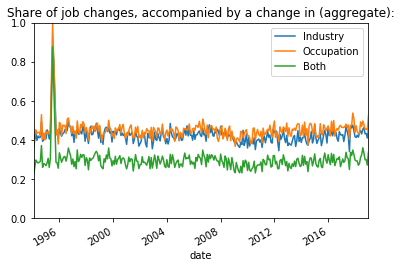

In [23]:
# Produce results
analyze(data_f_agg,
       'same_id & month_ok & EMPSAME == False & employed == True & lag_employed == True',
       'Job to job changes aggregate.csv',
       'Share of job changes, accompanied by a change in (aggregate):')

Our sample consists of 0.8% of input data
On average we observe 384.2 events per month


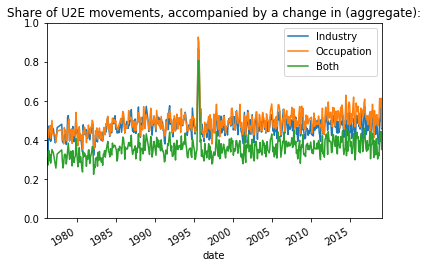

In [24]:
# Produce results
analyze(data_f_agg,
        'same_id & month_ok & employed == True & lag_employed == False',
        'U2E movements aggregate.csv',
        'Share of U2E movements, accompanied by a change in (aggregate):')

### Same commuting zone

I use the same procedure as before, except that now I also compute a lag of `czone`, and add an extra condition that for a job-to-job or U2E movement to be counted, `czone` and its lag must match.

In [25]:
# Add czone lags
data_f['czone_lag'] = data_f['czone'].shift(-1) 

Our sample consists of 0.3% of input data
On average we observe 138.6 events per month


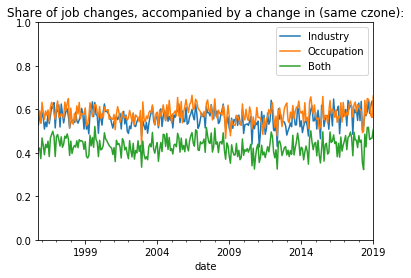

In [26]:
# Produce results
analyze(data_f,
       'same_id & month_ok & EMPSAME == False & employed == True & lag_employed == True & (czone == czone_lag)',
       'Job to job changes same czone.csv',
       'Share of job changes, accompanied by a change in (same czone):')

Our sample consists of 0.2% of input data
On average we observe 81.3 events per month


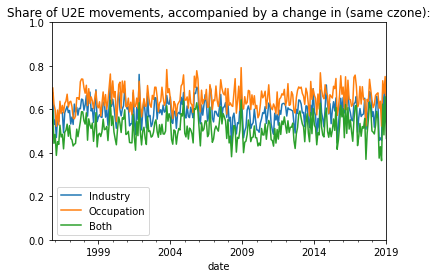

In [27]:
# Produce results
analyze(data_f,
        'same_id & month_ok & employed == True & lag_employed == False & (czone == czone_lag)',
        'U2E movements same czone.csv',
        'Share of U2E movements, accompanied by a change in (same czone):')

### By gender

Here I just split the dataset into two (by gender), and perform the same analysis on both

Our sample consists of 0.4% of input data
On average we observe 192.5 events per month


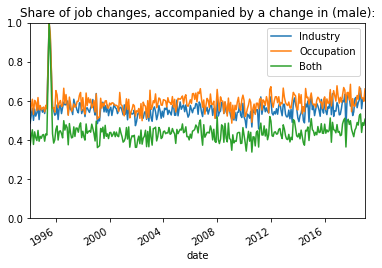

In [28]:
# Produce results (male j2j)
analyze(data_f,
       'same_id & month_ok & EMPSAME == False & employed == True & lag_employed == True & SEX == 1',
       'Job to job changes male.csv',
       'Share of job changes, accompanied by a change in (male):')

Our sample consists of 0.4% of input data
On average we observe 171.8 events per month


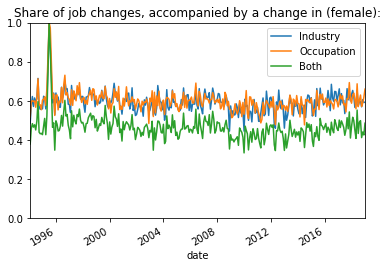

In [29]:
# Produce results (female j2j)
analyze(data_f,
       'same_id & month_ok & EMPSAME == False & employed == True & lag_employed == True & SEX == 2',
       'Job to job changes female.csv',
       'Share of job changes, accompanied by a change in (female):')

Our sample consists of 0.5% of input data
On average we observe 220.7 events per month


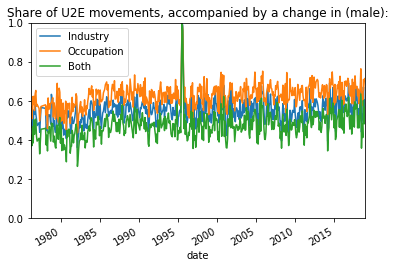

In [30]:
# Produce results (male u2e)
analyze(data_f,
       'same_id & month_ok & employed == True & lag_employed == False & SEX == 1',
       'U2E movements male.csv',
       'Share of U2E movements, accompanied by a change in (male):')

Our sample consists of 0.3% of input data
On average we observe 163.5 events per month


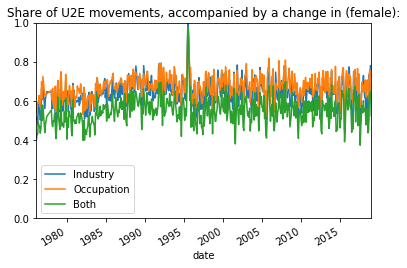

In [31]:
# Produce results (female u2e)
analyze(data_f,
       'same_id & month_ok & employed == True & lag_employed == False & SEX == 2',
       'U2E movements female.csv',
       'Share of U2E movements, accompanied by a change in (female):')

### Unemployment to employment transitions - alternative

Here I use the alternative approach to estimating U2E transitions, which is I take the previous value of employment/occupation to be the value held when the person was last employed (if he was). As not many people have been employed twice, and unemployed in between, this significantly decreases the size of the sample.

This problem of getting the earliest date of previous employment could be potentially very computationally demanding, so I use some "shortcuts". First, the maximum number of months that a person is in the CPS turns out to be 8. This means that after we sort date by id and date, we need only check (max) 8 lags to determine previous industry/occupation, if any. 

The procedure I use is the following (given here for industry, same for occupation):
- I copy `data_f`, which already has month/id lags needed, and is sorted
- I create several lags (max. frequency of any person in CPS - 1) of the employment variable, and the same amount of lags (+ current value) for the id variable 
- I move all these lags to a new dataframe called `lags`
- For each row in `lags`, I get the first value where one of the employment lags is `True` (remember, I do not have the current employment value in `lags`). This corresponds to the closest month the person was employed, assuming the lagged value belongs to the same person. I put these values in a series `max_e`. I also calculate the value of employment at this lag, `last_e`,
- I take the lag of industry variable corresponding to the lag in `last_e`.
- If 
    + current id and lag of it corresponding to `last_e` match
    + employment was true at `last_e` (so `last_e == True`)
    
  I return the corresponding (to `max_e`) lag of the industry variable, otherwise I return NA

In this way, I return precisely the value of the industry variable when the individual was last employed (not counting current period).

Next, I drop all rows where previous industry is NA. From here on I compute the weighted means exactly as before.

In [32]:
# Copy data_fu2e
data_fu2e_a = data_f.copy()

# Maximum duration of an individual in the sample is the max number of lags
# Lags start with 1!
max_lag = data_fu2e_a['CPSIDP'].value_counts().max() - 1

# Prepare lags of employed and id, get value 
lags = [data_fu2e_a['employed'].shift(-(i+1)) for i in range(max_lag)]
lags = pd.concat(lags, axis = 1)
lags_id = [data_fu2e_a['CPSIDP'].shift(-(i+1)) for i in range(max_lag)]

# Get the value of employment and ID at max employment lag
max_e = lags.values.argmax(axis = 1)
last_e = lags.values.max(axis = 1)
last_id = max_e.choose(lags_id)

# Is the ID the same, and is the max_e true (was the person employed?)
last_ok = (last_e == True) & (last_id == data_fu2e_a['CPSIDP'])

# Clean up 
del lags_id, lags

In [33]:
# Helper function to get var value at last employment
def var_last_employment(var_name):  
    lags_v = [data_fu2e_a[var_name].shift(-(i+1)) for i in range(max_lag)]
    last_v = max_e.choose(lags_v)
    
    # Filter only to values where id and employed are ok
    last_v[~last_ok] = None
    
    # Clean up
    del lags_v
    
    return last_v

In [34]:
# Ok, let's get previous industry and occupation
data_fu2e_a['prev_ind'] = var_last_employment('IND1990')
data_fu2e_a['prev_occ'] = var_last_employment('OCC2010')

data_fu2e_a['occ_changes'] = data_fu2e_a['OCC2010'] != data_fu2e_a['prev_occ']
data_fu2e_a['ind_changes'] = data_fu2e_a['IND1990'] != data_fu2e_a['prev_ind']
data_fu2e_a['both_change'] = data_fu2e_a['occ_changes'] & data_fu2e_a['ind_changes']

Our sample consists of 0.5% of input data
On average we observe 181.2 events per month


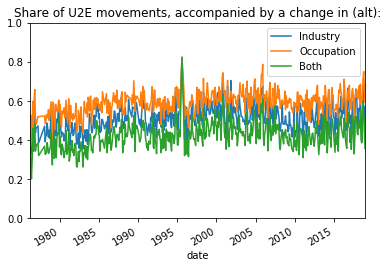

In [35]:
# Produce results
analyze(data_fu2e_a.dropna(subset = ['prev_ind']),
       'same_id & month_ok & employed == True & lag_employed == False',
       'U2E movements alt.csv',
       'Share of U2E movements, accompanied by a change in (alt):')